# Laser Template Comparisons from the Summer 2017 Commissioning Run

In [1]:
import ROOT as r
import numpy as np
gm2calo_dir = '~/g-2/art/devAreaV7/srcs/gm2calo'
laser_template_dir = 'g2RunTimeFiles/commissioningTemplates/laserTemplates'

Welcome to JupyROOT 6.08/06


## First, I'll examine variation of pulse shapes within each calorimeter.

In [2]:
def get_spline_func(spline):
    return lambda x: spline.Eval(x[0]/1.25)

def overlay_calo_templates(calo_num):
    files = [r.TFile('{0}/{1}/calo{2}LaserTemplates/laserTemplateFile{3}.root'.format(
        gm2calo_dir,laser_template_dir, calo_num,i)) for i in range(54)]
    functions = []
    amplitudes = []
    for i, f in enumerate(files):
        spline = f.Get('masterSpline')
        functions.append(r.TF1('f{0}_{1}'.format(calo_num, i), get_spline_func(spline), -7, 30, 0))
        functions[-1].SetNpx(1000)
        functions[-1].SetLineWidth(1)
        functions[-1].SetTitle('calo {}; t [ns]; T(t)'.format(calo_num))
        if i == 0:
            functions[-1].Draw()
            functions[-1].GetYaxis().SetRangeUser(-0.04,0.45)
        else:
            functions[-1].Draw("same")
        amplitudes.append(functions[-1].GetMaximum())
    for f in files:
        f.Close()
    return functions, amplitudes

def make_calo_plots(calo_num):
    c = r.TCanvas()
    functions, amplitudes = overlay_calo_templates(calo_num)
    c.Draw()

    c2 = r.TCanvas()
    amp_graph = r.TGraph()
    amp_graph.SetTitle('calo {}; xtal num; amplitude / area'.format(calo_num))
    for i, amp in enumerate(amplitudes):
        amp_graph.SetPoint(i, i, amp)
    amp_graph.Draw('ap')
    amp_graph.GetXaxis().SetLimits(-1,54)
    amp_graph.GetYaxis().SetRangeUser(0, 0.7)
    
    lines = []
    lines.extend([r.TLine(-1,0.32,54,0.32), r.TLine(-1,0.42,54,0.42)])
    for line in lines:
        line.SetLineStyle(2)
        line.Draw()
    
    c2.Draw()
    objs = [c, c2, functions, amp_graph, lines]
    return objs

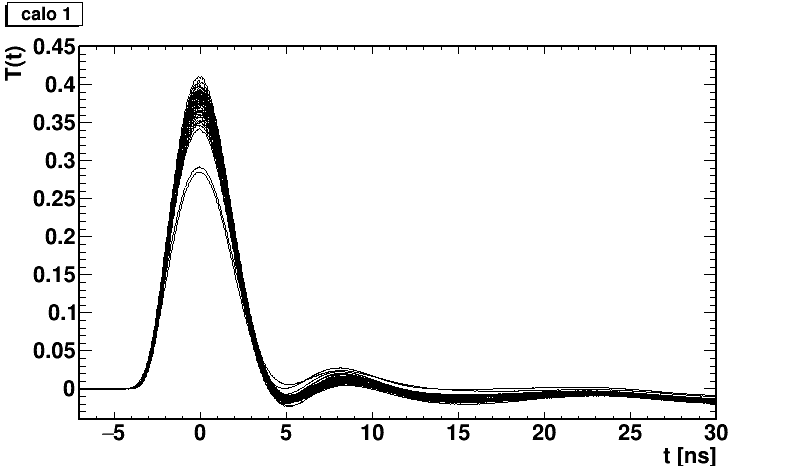

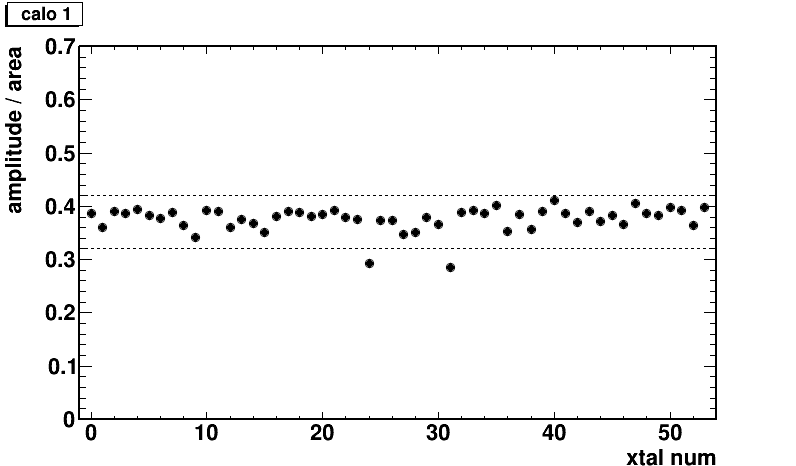

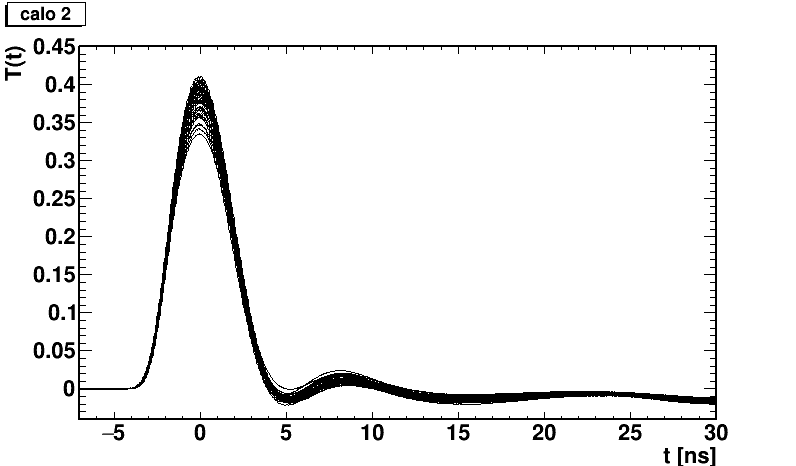

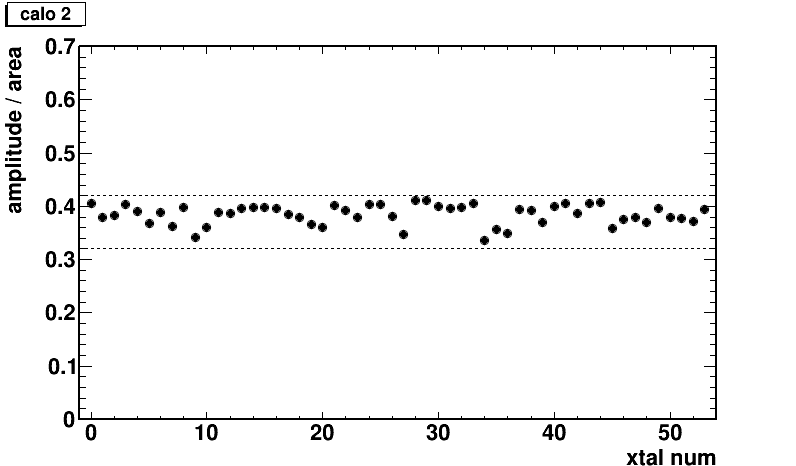

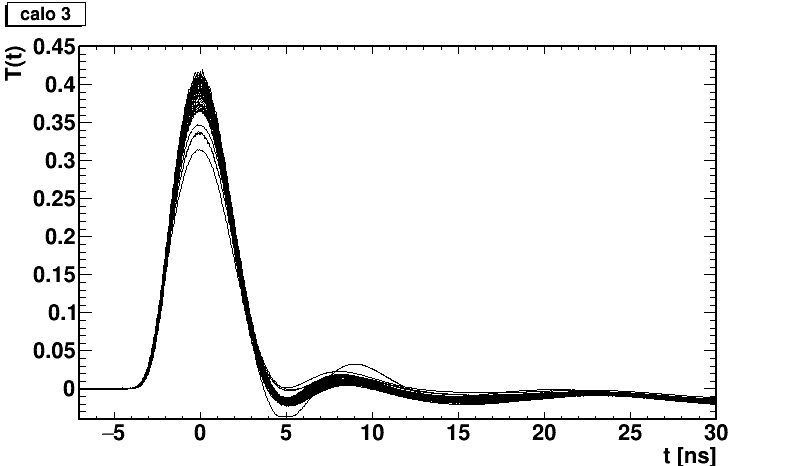

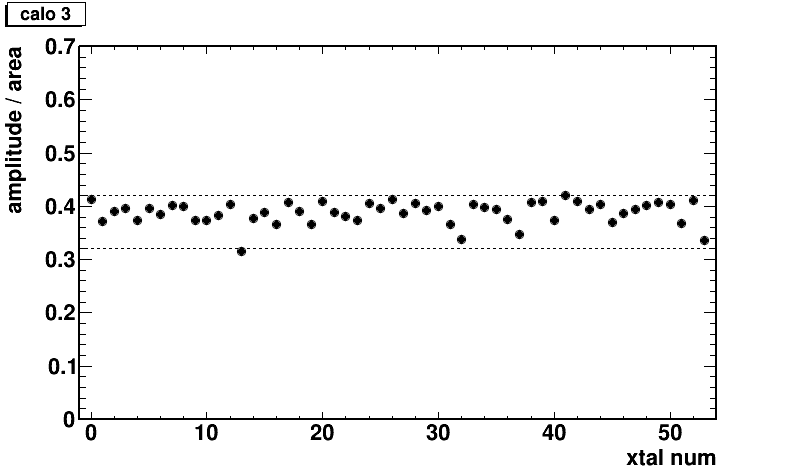

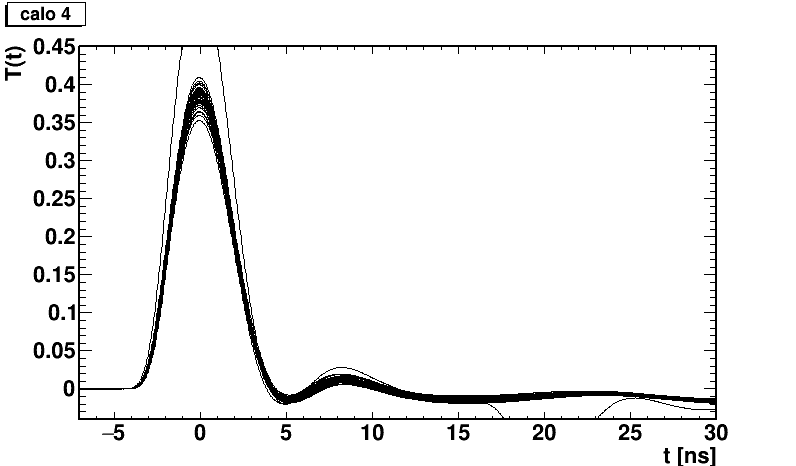

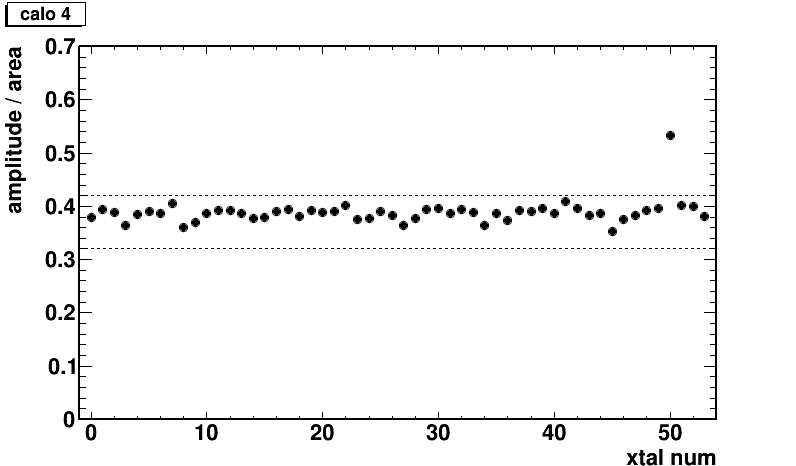

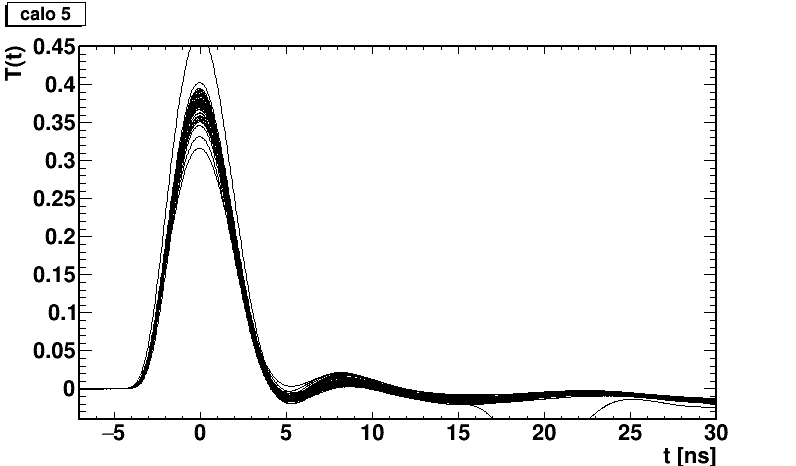

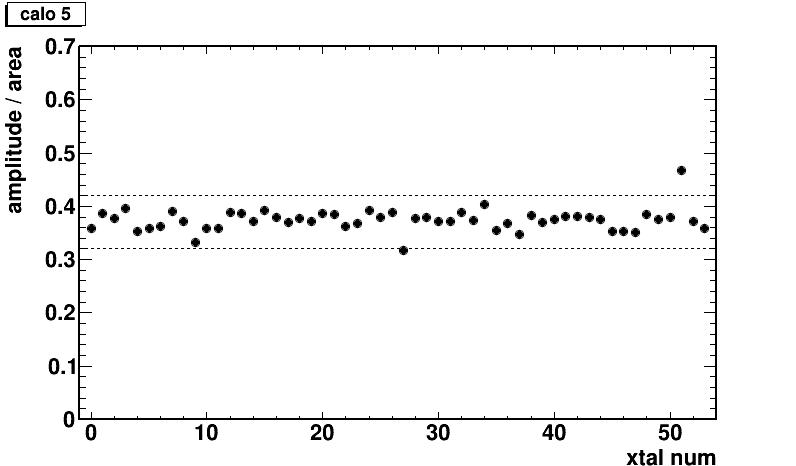

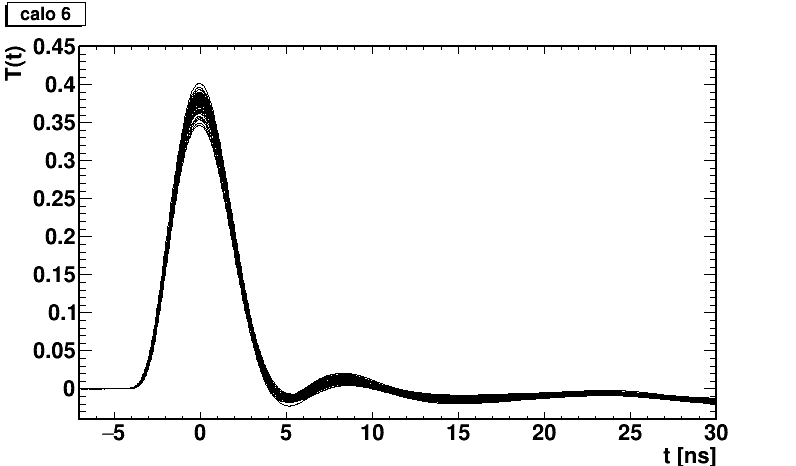

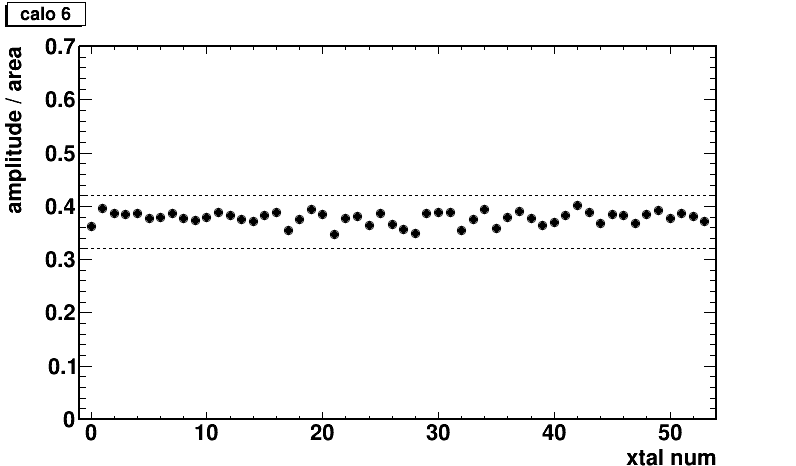

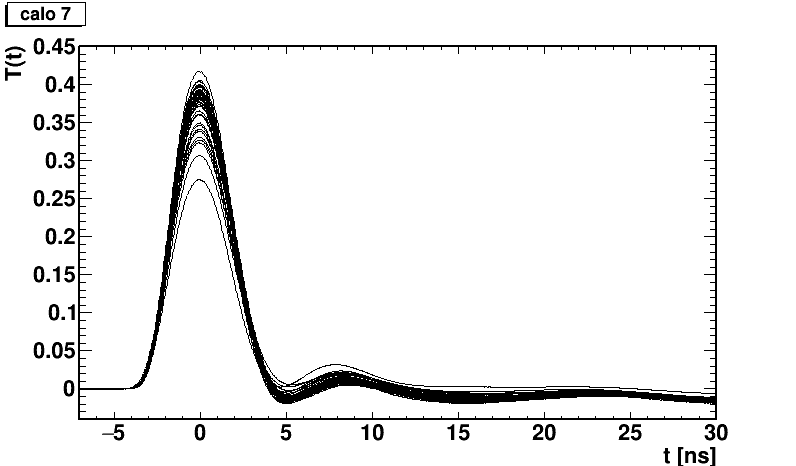

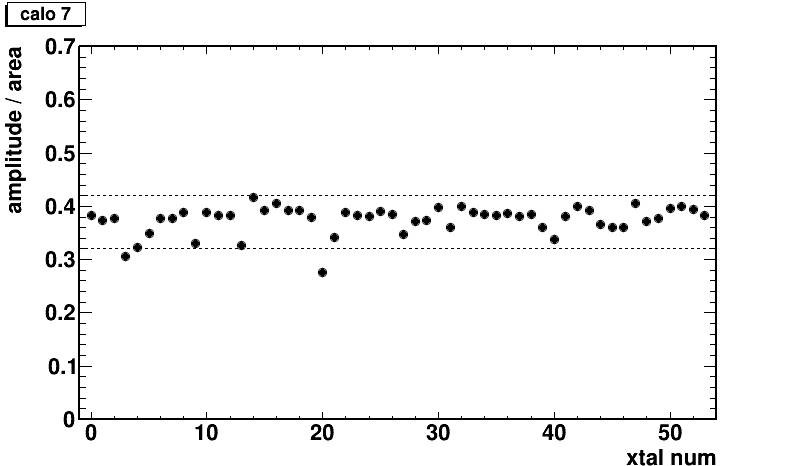

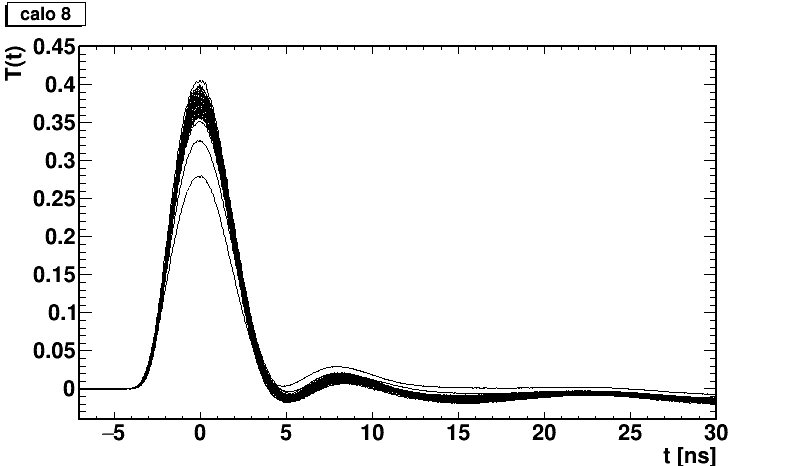

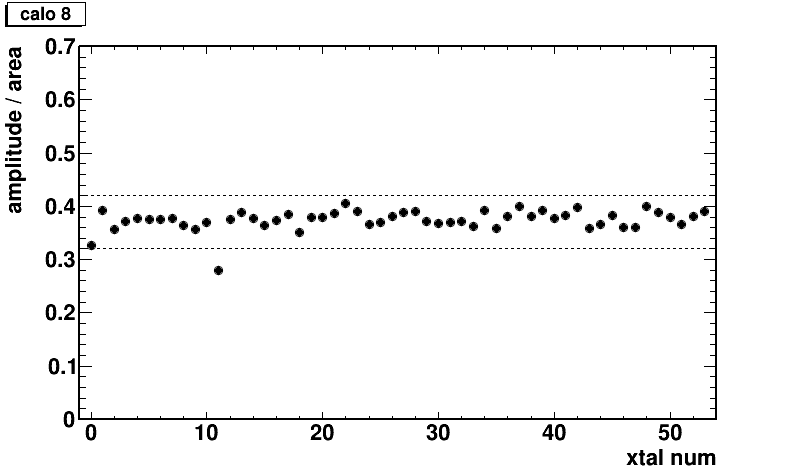

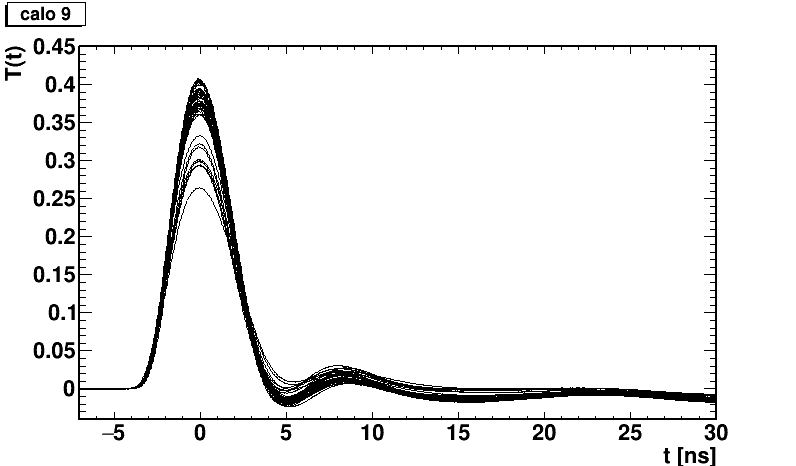

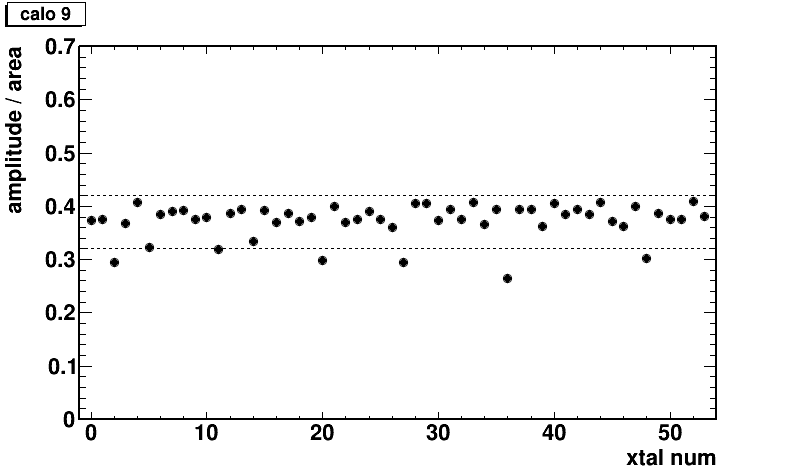

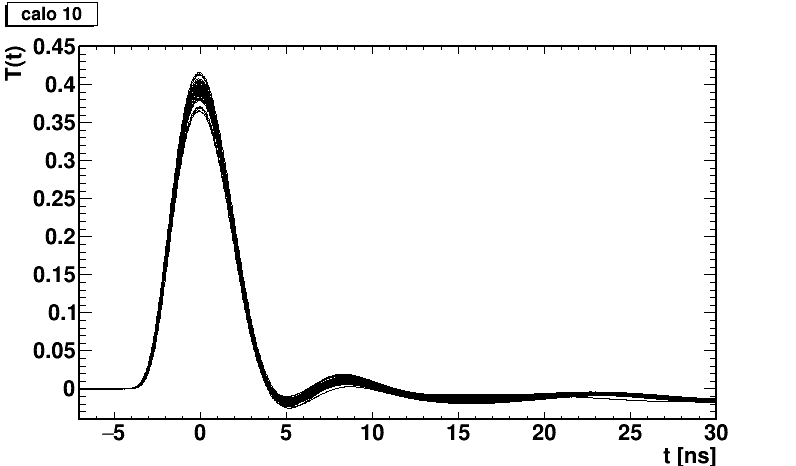

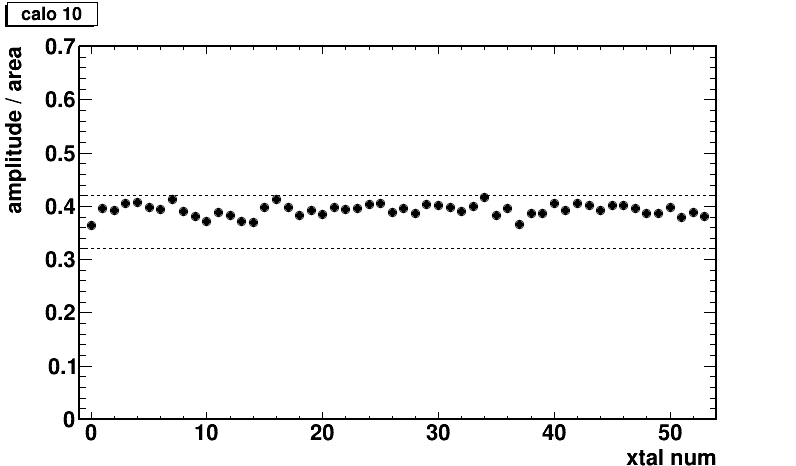

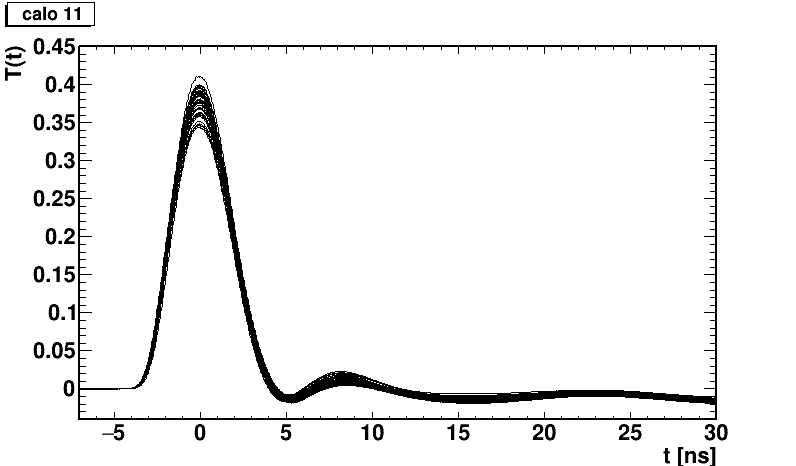

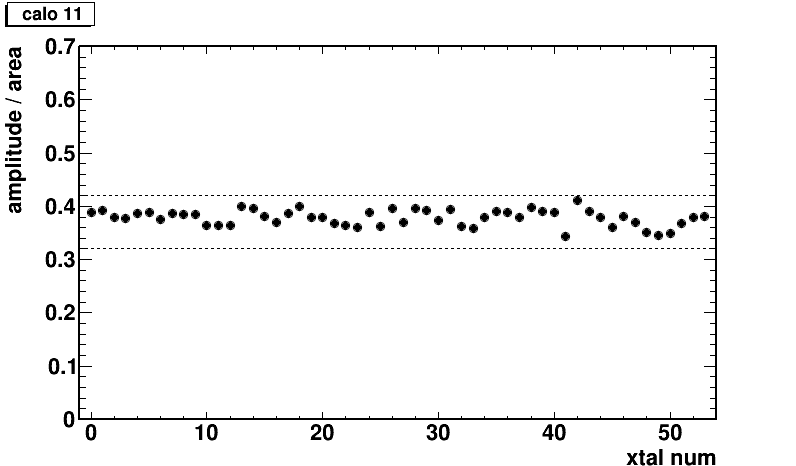

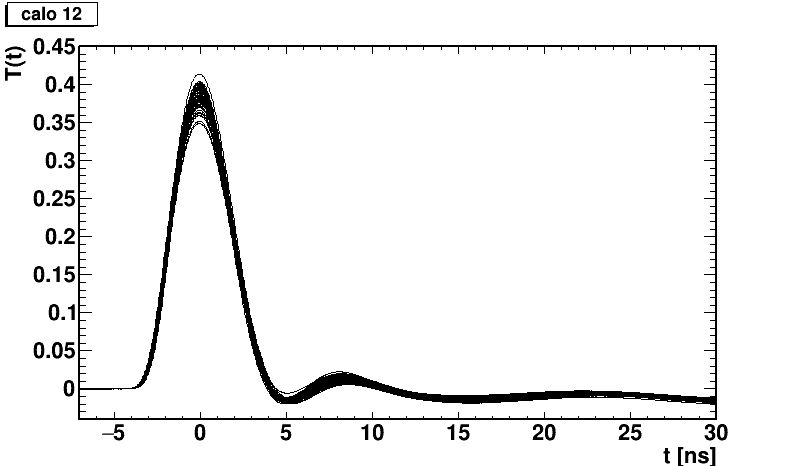

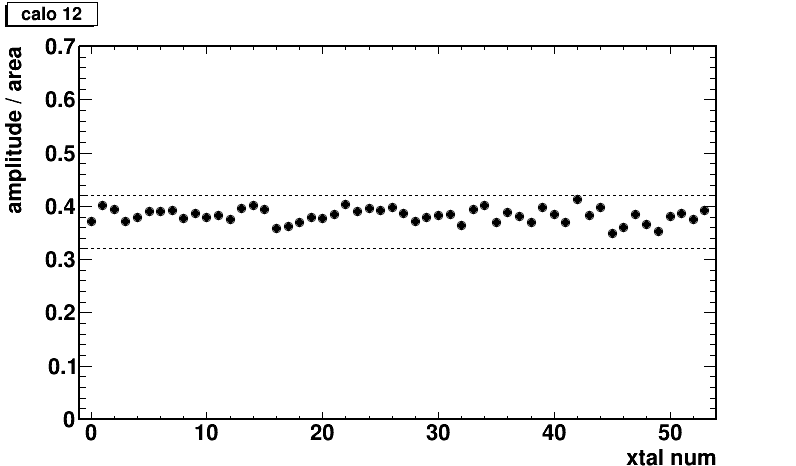

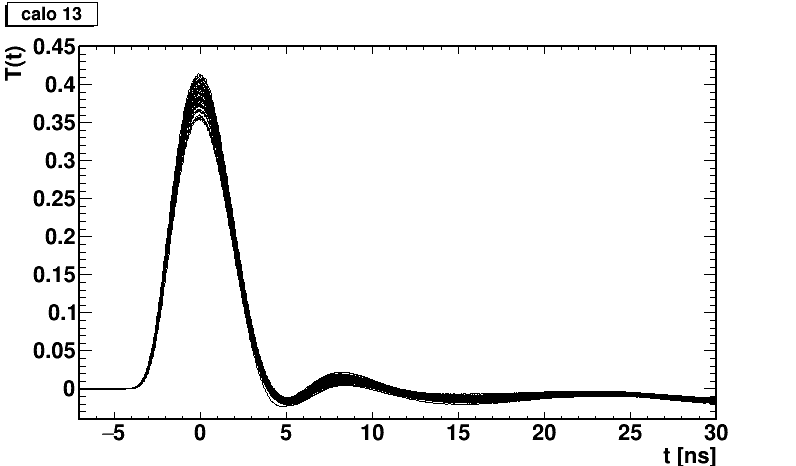

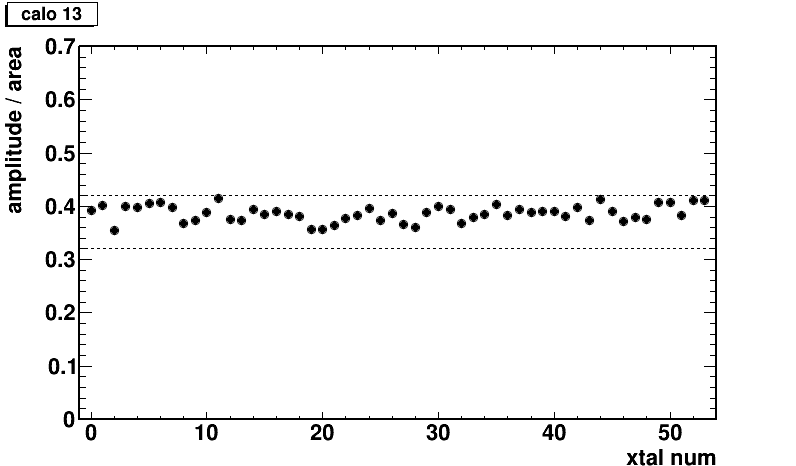

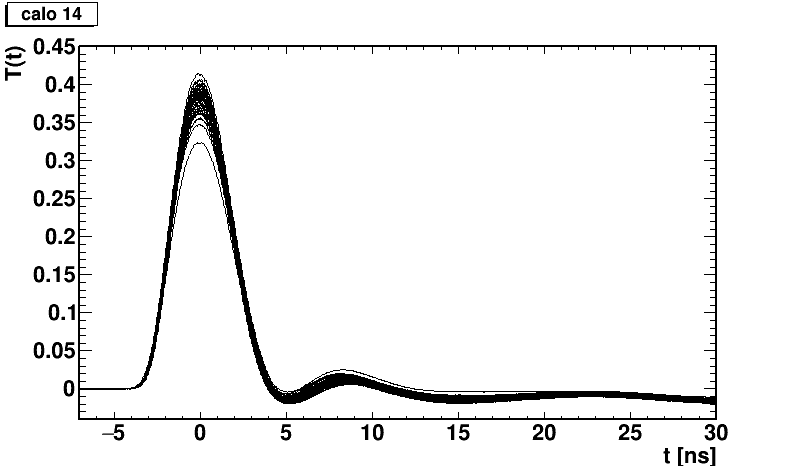

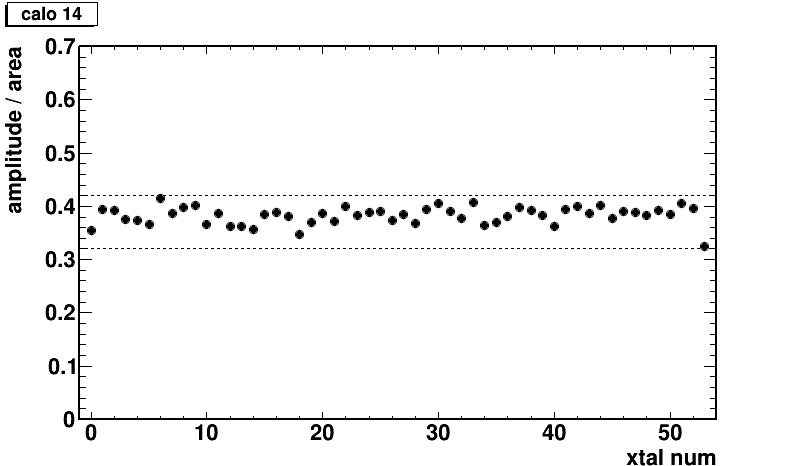

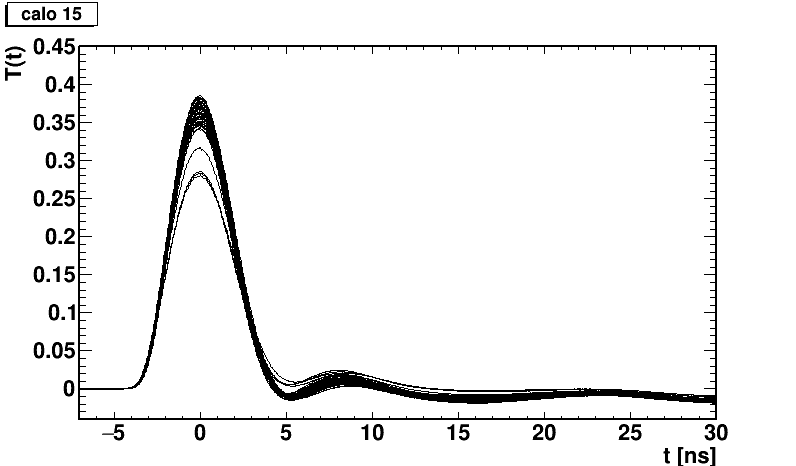

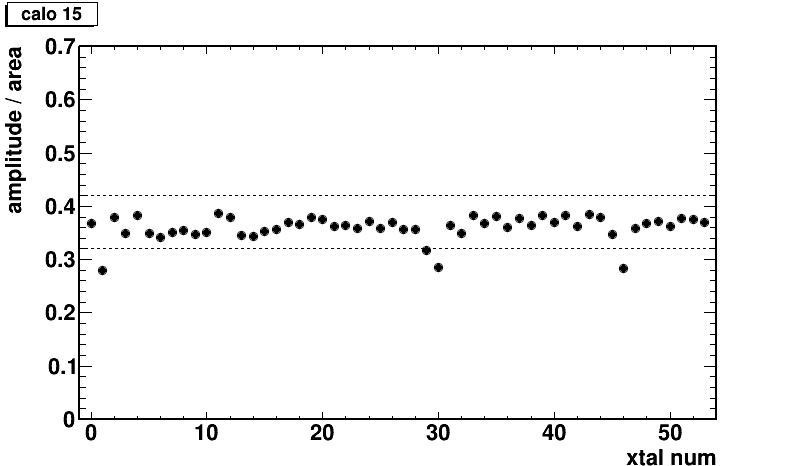

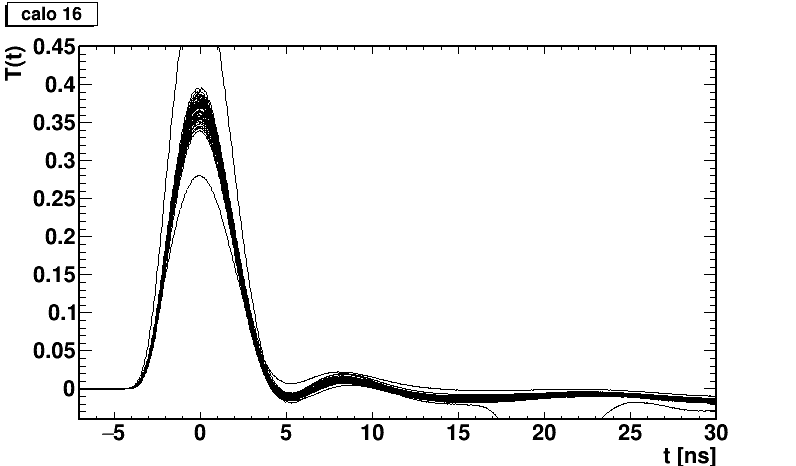

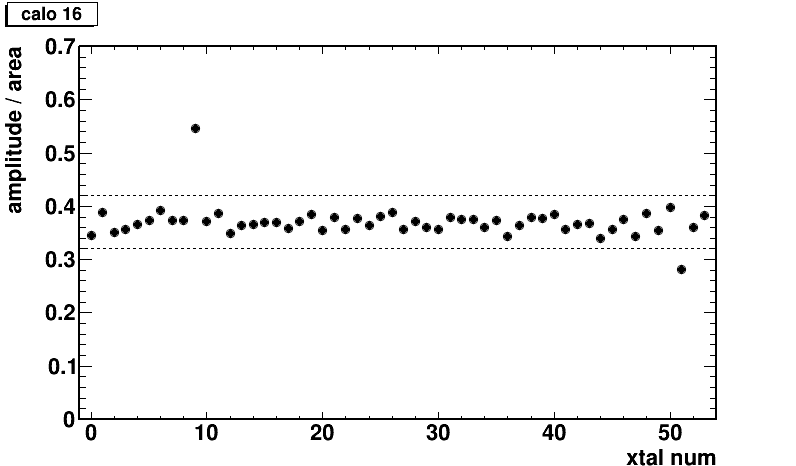

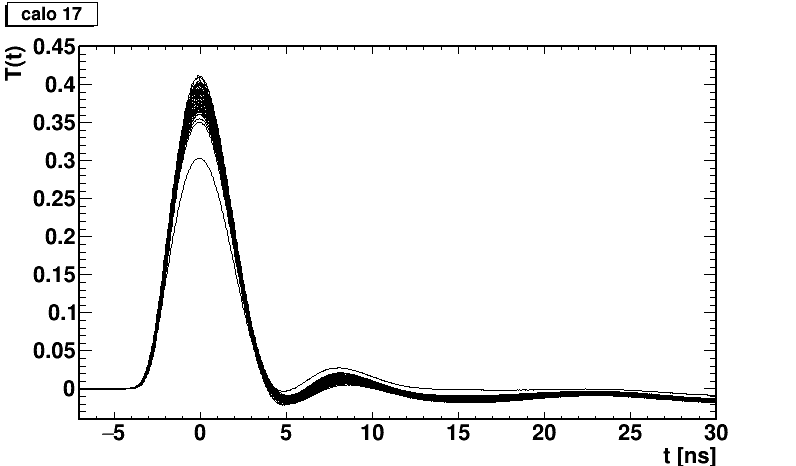

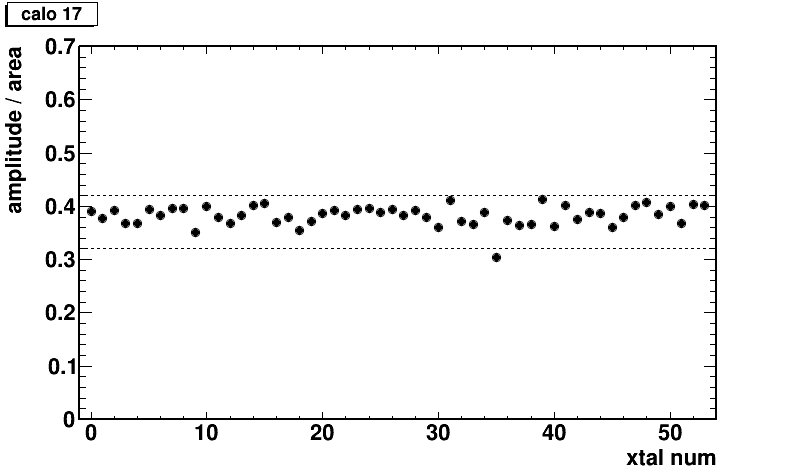

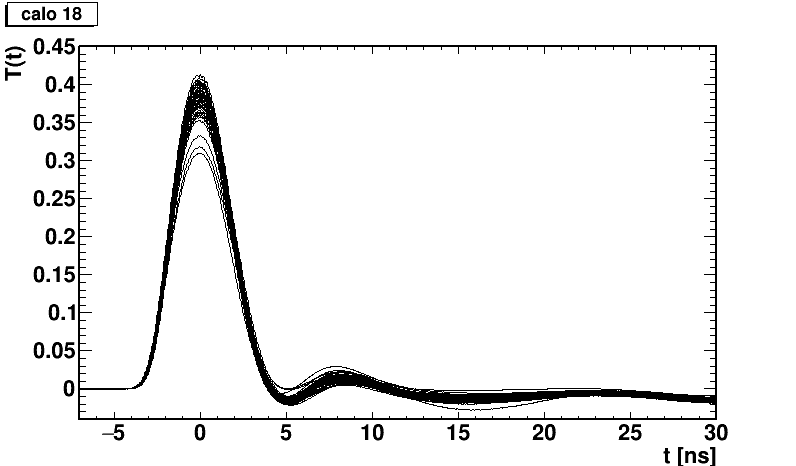

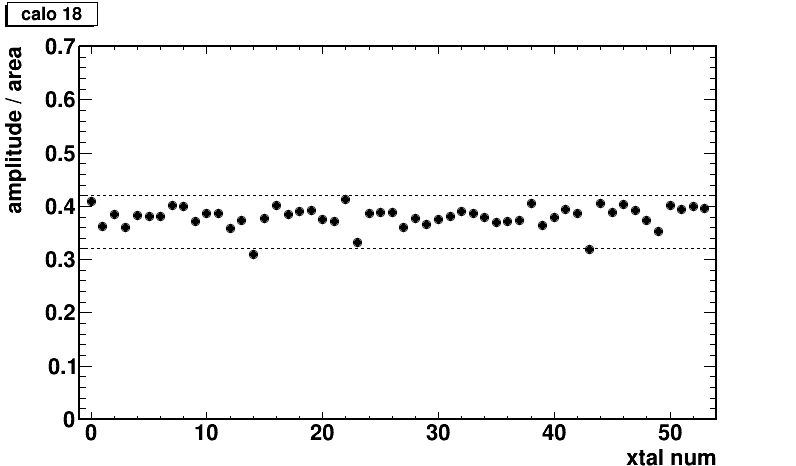

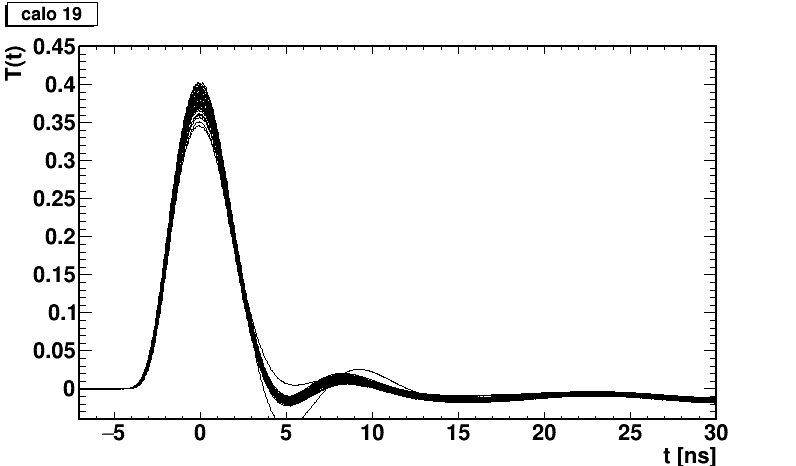

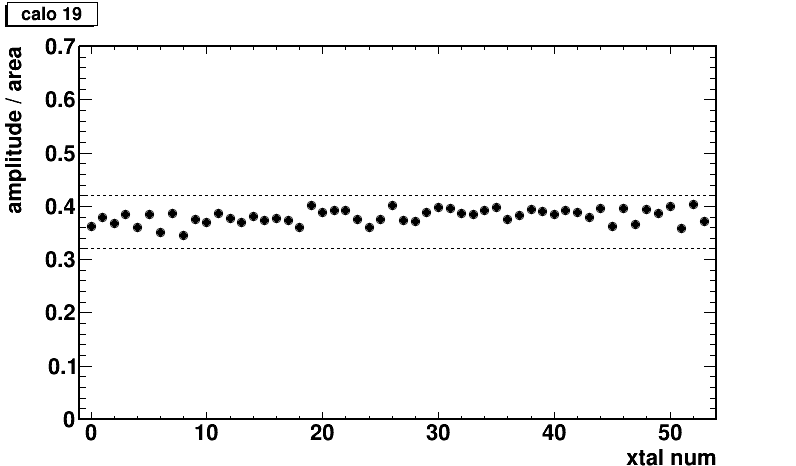

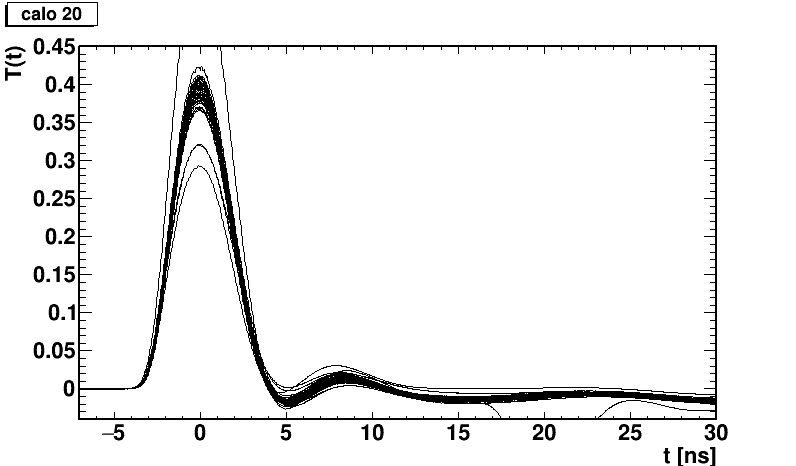

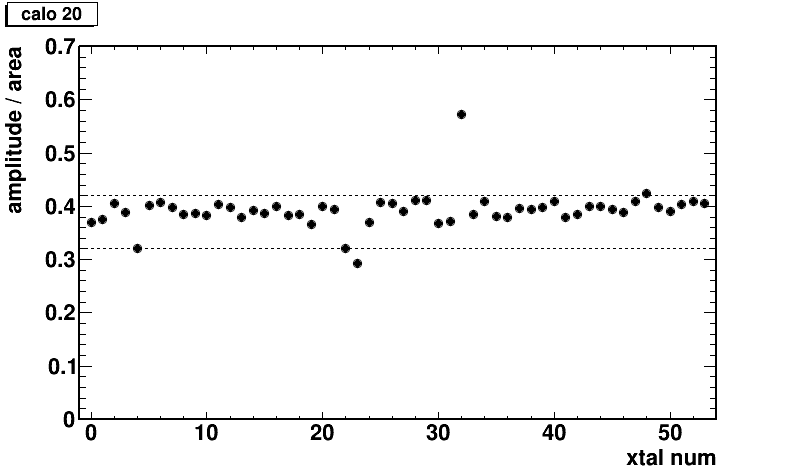

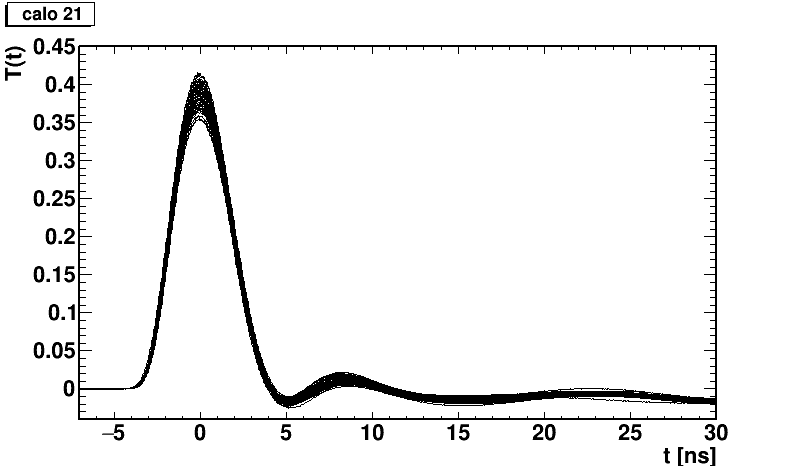

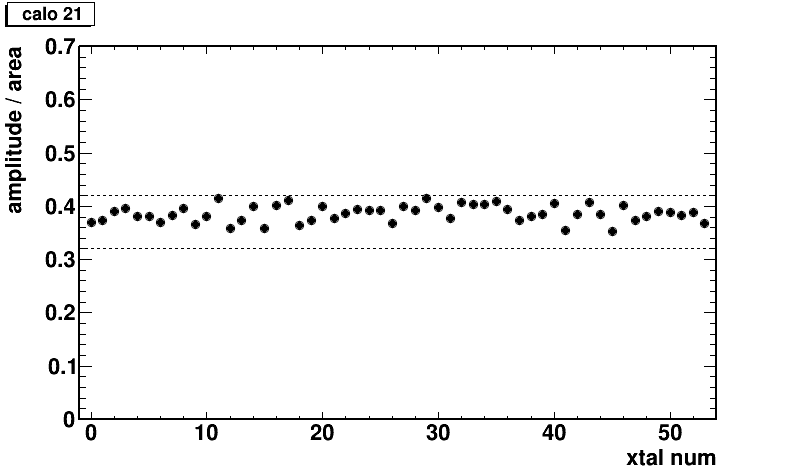

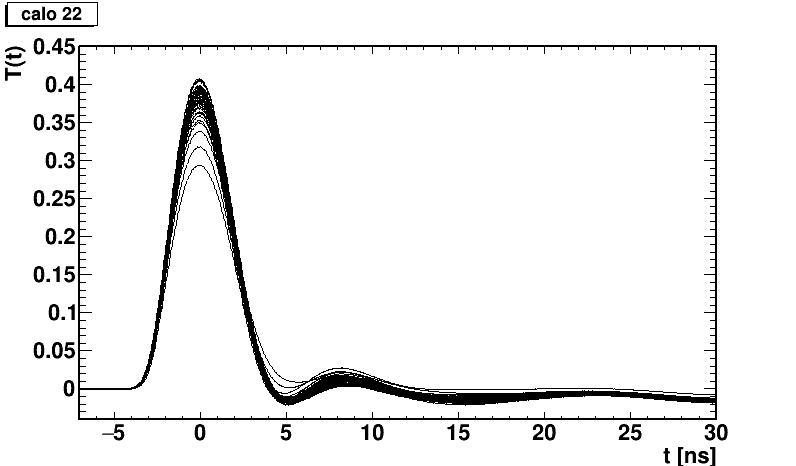

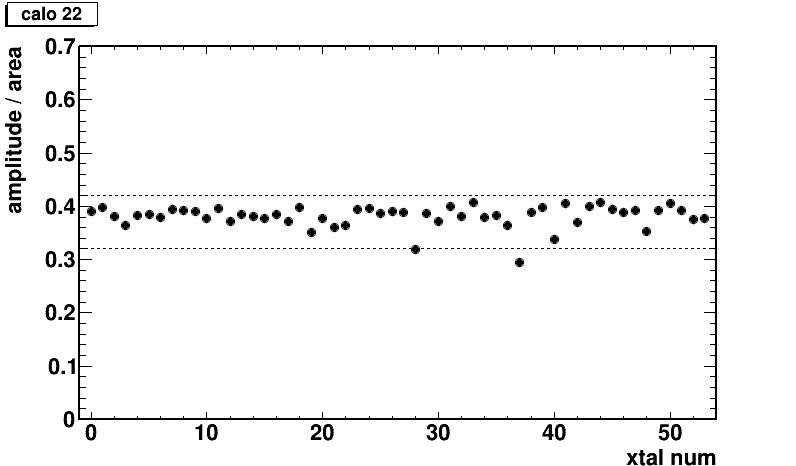

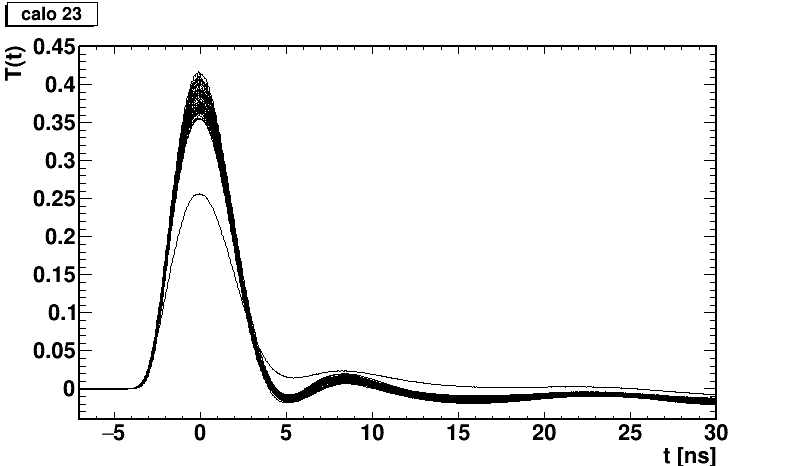

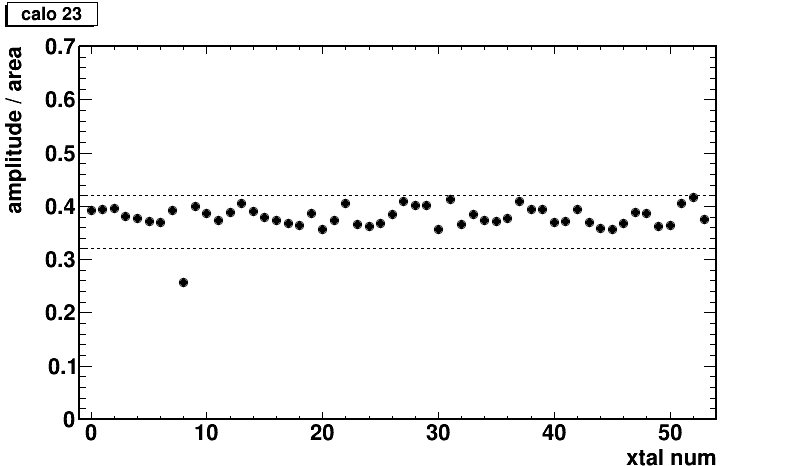

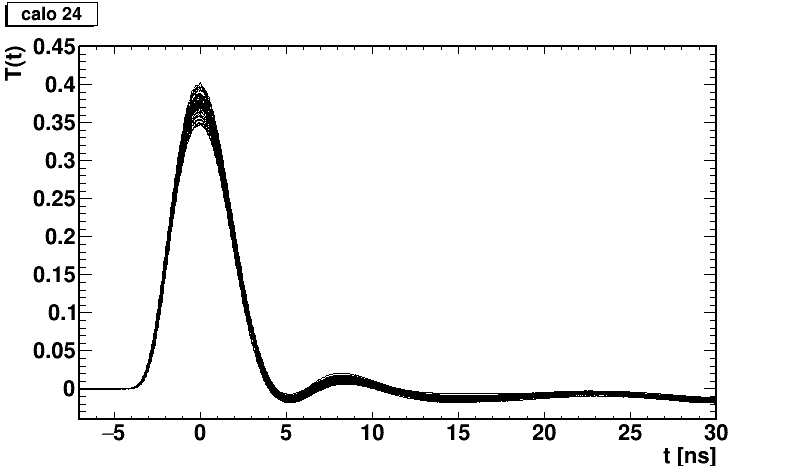

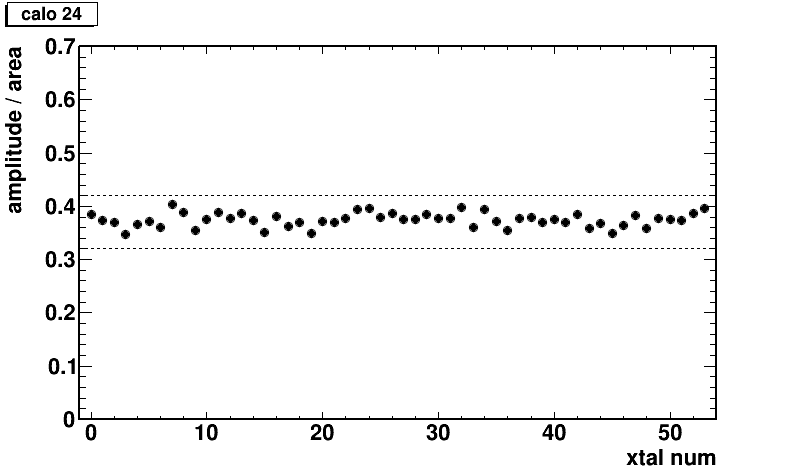

In [3]:
objs = []
for i in range(1,25):
    objs.append(make_calo_plots(i))

### Most crystals have an amplitude / area between 0.32 and 0.42. Some outliers are caused by poor signal cables that have since been replaced and some have a much smaller overshoot than a typical pulse. The smaller overshoot could be caused by saturation. Crystals with amplitude / area values falling outside of the bands shown above will be excluded from the per-calo average templates.

# Now we'll look at per-calo average templates. We're looking for a detectable pulse shape difference between different calorimeters and different laser heads.

In [4]:
def build_calo_avg_template(calo_num):
    good_splines = []
    amps = []
    for i in range(54):
        spline_f = r.TFile('{0}/{1}/calo{2}LaserTemplates/laserTemplateFile{3}.root'.format(
        gm2calo_dir,laser_template_dir, calo_num,i))
        spline = spline_f.Get('masterSpline')
        func = r.TF1('splineF', get_spline_func(spline), -7, 30, 0)
        amp = func.GetMaximum()
        if 0.32 < amp < 0.42:
            amps.append(amp)
            good_splines.append(spline)
        spline_f.Close()
        
    avg_func = r.TF1('avg_shape_{}'.format(calo_num), 
                     lambda x: sum(s.Eval(x[0]/1.25) for s in good_splines) / len(good_splines),
                    -7, 30, 0)
    avg_func.SetNpx(1000)
    ampl_avg_err = np.std(amps)/np.sqrt(len(good_splines))
    return avg_func, ampl_avg_err

#### Example of an average template:

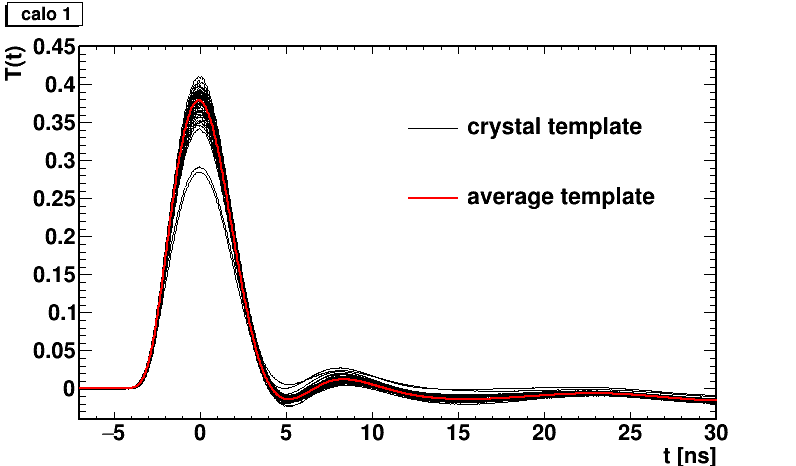

In [5]:
ca = r.TCanvas()
funcs, _ = overlay_calo_templates(1)
func1, _ = build_calo_avg_template(1)
func1.SetLineColor(r.kRed)
func1.Draw("same")

leg = r.TLegend(0.5,0.8,0.85, 0.5)
leg.SetLineColor(r.kWhite)
leg.SetFillColor(r.kWhite)
leg.SetShadowColor(r.kWhite)
leg.AddEntry(funcs[0], 'crystal template', 'l')
leg.AddEntry(func1, 'average template', 'l')
leg.Draw()

ca.Draw()

#### Overlay all averages

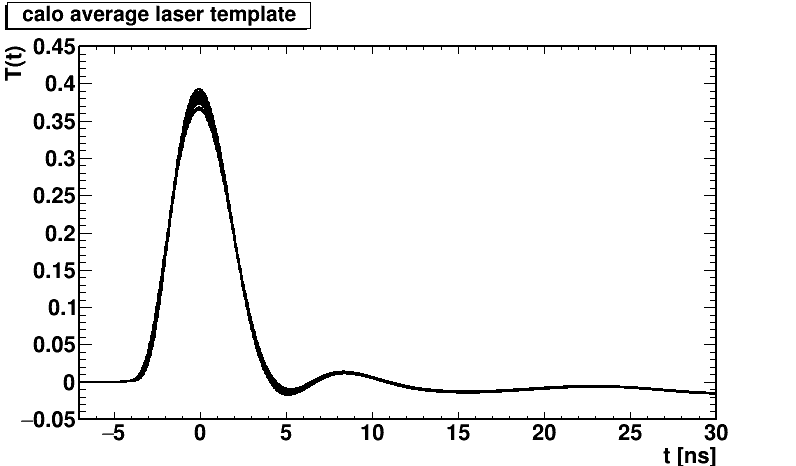

In [6]:
overlay_canv = r.TCanvas()
avgs, errs = zip(*[build_calo_avg_template(i) for i in range(1,25)])
avgs[0].Draw()
avgs[0].GetYaxis().SetRangeUser(-0.05, 0.45)
avgs[0].SetTitle("calo average laser template; t [ns]; T(t)")
for avg in avgs[1:]:
    avg.Draw('same')
overlay_canv.Draw()

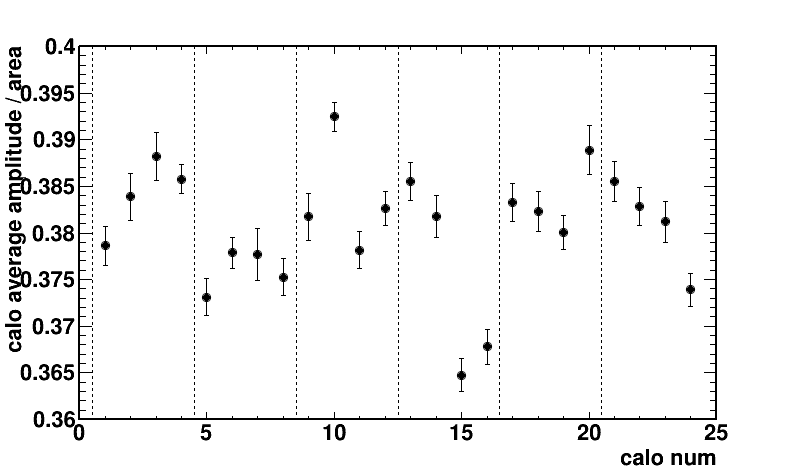

In [7]:
ampls = [avg.GetMaximum() for avg in avgs]
calo_avg_ampls = r.TGraphErrors()
for i, (ampl, err) in enumerate(zip(ampls,errs)):
    calo_avg_ampls.SetPoint(i, i+1, ampl)
    calo_avg_ampls.SetPointError(i, 0, err)
calo_avg_ampls.SetTitle(';calo num; calo average amplitude / area')
calo_avg_ampls.GetXaxis().SetLimits(0,25)
calo_avg_ampls.GetYaxis().SetRangeUser(0.36,0.4)
calo_avg_ampls.Draw("ap")
ls = []
for i in range(6):
    x = 1+4*i-0.5
    l = r.TLine(x, 0.36, x, 0.4)
    l.SetLineStyle(2)
    l.Draw()
    ls.append(l)
overlay_canv.Draw()

### No obviously clear differences between different laser heads. Maybe there is a hint of some significant differences between certain calo pairs, but the spread imparted by the SiPM pulse shape variations within a calo seems large compared to systematic differences between calorimeters and laser heads.

## Make master average pulse shape, look at $\int_{-10}^{t} T(t')dt'$

In [8]:
# use python now, it is a bit faster and more convenient
def build_master_avg_template():
    good_splines = []
    amps = []
    for calo_num in range(1,24):
        for i in range(54):
            spline_f = r.TFile('{0}/{1}/calo{2}LaserTemplates/laserTemplateFile{3}.root'.format(
                gm2calo_dir,laser_template_dir, calo_num,i))
            spline = spline_f.Get('masterSpline')
            func = r.TF1('splineF', get_spline_func(spline), -7, 30, 0)
            amp = func.GetMaximum()
            if 0.32 < amp < 0.42:
                good_splines.append(spline)
            spline_f.Close()
        
    # for this one, we'll keep the area normalization the same
    constant = 1.0/1.25
    xs = np.linspace(-20,180,10000)
    ys = constant*np.array([np.sum(spline.Eval(x/1.25) for spline in good_splines)/len(good_splines) for x in xs])
    return xs, ys

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('dark')
plt.rcParams['figure.figsize'] = 16, 8

In [10]:
xs, ys = build_master_avg_template()

In [11]:
integrals = np.array([np.trapz(ys[:i], xs[:i]) for i,_ in enumerate(xs)])

(-20.0, 180.0)

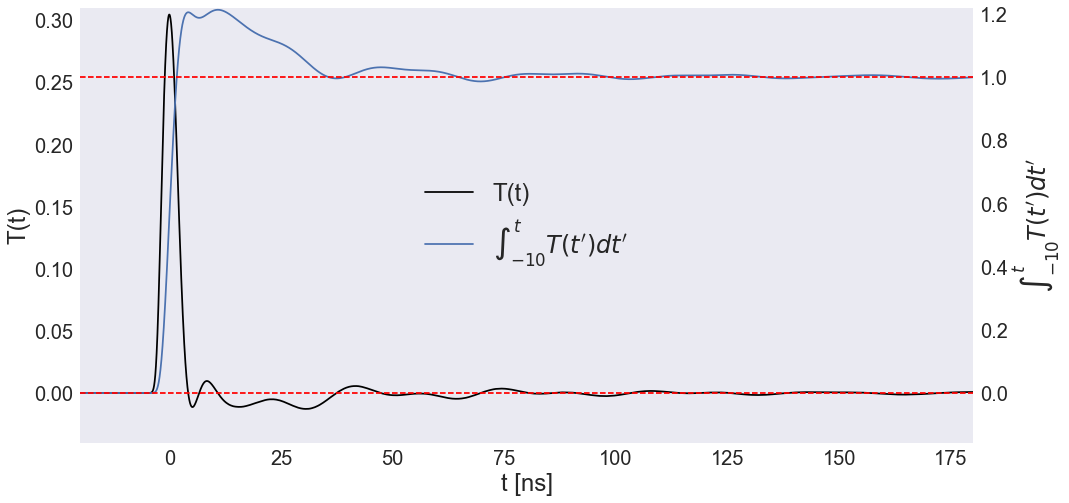

In [12]:
_,ax1 = plt.subplots()
ax1.set_ylim(-0.04,0.31)
ax2 = ax1.twinx()
ax1.set_xlabel('t [ns]',fontsize=24)
ax1.set_ylabel('T(t)',fontsize=24)
ax2.set_ylabel('$\int_{-10}^{t} T(t\')dt\'$',fontsize=24)
ax2.set_ylim((-0.04/0.31)*1.22, 1.22)
templ,=ax1.plot(xs, ys, 'k-', label='T(t)')
integral,=ax2.plot(xs, integrals, label='$\int_{-10}^{t} T(t\')dt\'$')
ax1.legend(handles=[templ,integral], loc='center', fontsize=24)
ax2.plot([xs[0], xs[-1]],[1,1],'r--')
ax2.plot([xs[0], xs[-1]],[0,0],'r--')
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax1.set_xlim(xs[0],xs[-1])

### FFT the master average template

In [13]:
time_step = xs[1]-xs[0]
size = xs.size
freqs = np.fft.fftfreq(size, time_step)
power = np.abs(np.fft.fft(ys))**2

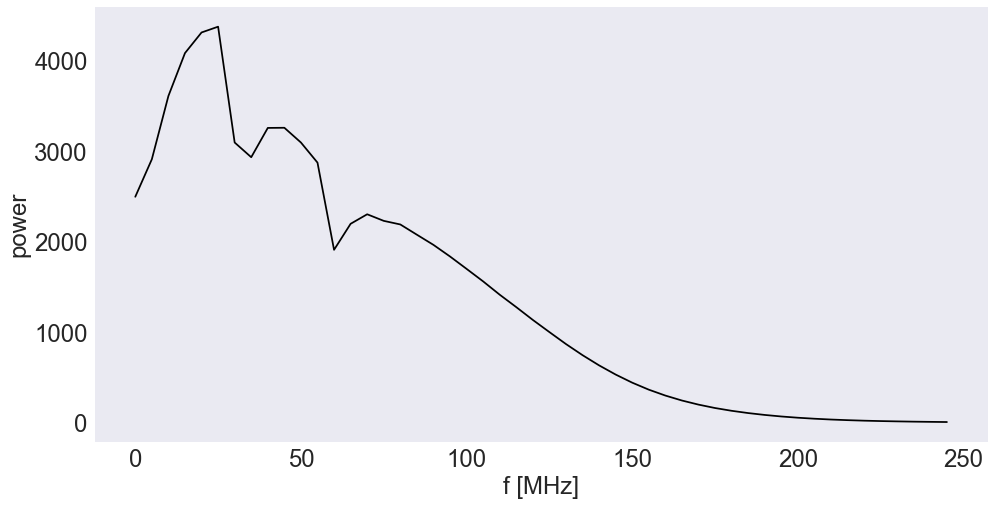

In [14]:
plt.plot(freqs[:size/200]*1000,power[:size/200], 'k-')
plt.xlabel('f [MHz]', fontsize=24)
plt.ylabel('power', fontsize=24)
plt.tick_params(labelsize=24)

### template derivative

In [15]:
t_prime = (ys[1:] - ys[:-1])/(xs[1:]-xs[:-1])
t_prime_xs = 0.5*(xs[:-1] + xs[1:])

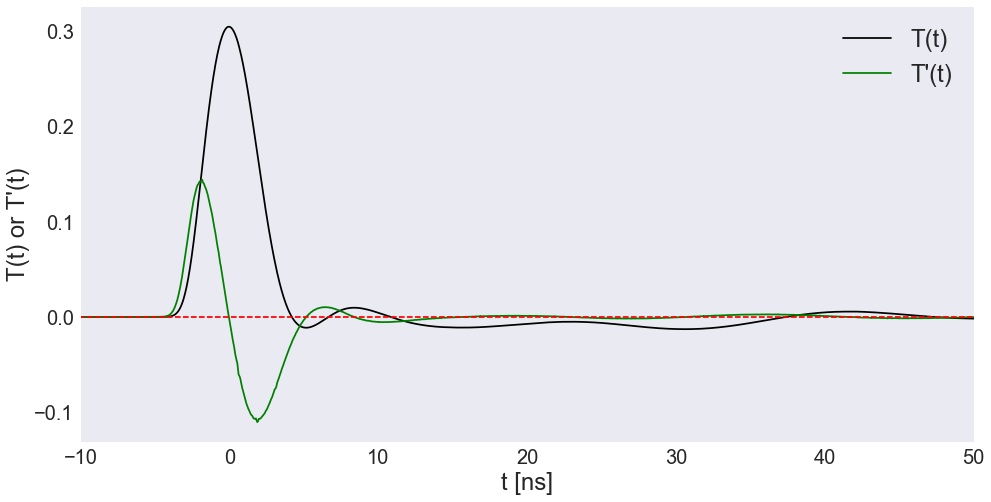

In [16]:
t_plot = plt.plot(xs, ys, 'k-', label='T(t)')
t_prime_plot = plt.plot(t_prime_xs, t_prime, 'g-', label='T\'(t)')
plt.xlim(t_prime_xs[0],t_prime_xs[-1])
plt.plot([t_prime_xs[0], t_prime_xs[-1]], [0,0], 'r--')
plt.legend(handles=[t_plot[0], t_prime_plot[0]], fontsize=24)
plt.xlabel('t [ns]', fontsize=24)
plt.ylabel('T(t) or T\'(t)', fontsize=24)
plt.xlim(-10,50)
plt.tick_params(labelsize=20)